# Setup Dependencies

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

 71% 21.0M/29.6M [00:00<00:00, 99.2MB/s]
100% 29.6M/29.6M [00:00<00:00, 92.8MB/s]


In [ ]:
!unzip semantic-segmentation-of-aerial-imagery.zip

Archive:  semantic-segmentation-of-aerial-imagery.zip
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_001.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_002.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_003.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_004.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_005.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_006.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_007.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_008.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_009.jpg  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_001.png  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_002.png  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_003.png  
  inflating: 

In [ ]:
!pip3 install -U patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 4.2 MB/s eta 0:00:00


In [ ]:
# Open the file in write mode
with open('/usr/local/lib/python3.9/dist-packages/efficientnet/keras.py', 'r') as f:
    # Read the contents of the file
    contents = f.read()

# Replace the string
new_contents = contents.replace('init_keras_custom_objects', 'init_tfkeras_custom_objects')

# Open the file in write mode again and write the modified contents
with open('/usr/local/lib/python3.9/dist-packages/efficientnet/keras.py', 'w') as f:
    f.write(new_contents)

In [ ]:
!pip3 install pyyaml h5py  # Required to save models in HDF5 format
!pip3 install keract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Library Imports

In [ ]:
# system
import os
import glob
import shutil

# calculation
import numpy as np 
import math
import random

# image processing & data
import cv2
from PIL import Image 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# model 
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Model,load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K
import segmentation_models as sm
import keract as ke

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

Segmentation Models: using `keras` framework.


# Load & Preprocess Data

### 1. Working out the structure of the dataset

In [ ]:
dataset_root_folder='/content/Semantic segmentation dataset'

In [ ]:
# for path,subdir,files in os.walk(dataset_root_folder):
#   dir_name=path.split(os.path.sep)[-1]
#   # print(dir_name)
#   if dir_name == 'images': # 'masks
#     images=os.listdir(path)
#     # print(path)
#     # print(images)
#     for i, img_name in enumerate(images):
#       if(img_name.endswith('.png')): # '.jpg'
#         # print(img_name)
#         a=True

### 2. Create a general function to get any image from the structure of directories

In [ ]:
# gets image as an ndarray
# arg 1: title_id | 1-8
# arg 2: im_type | 'i','m'
# arg 3: idx | 1-9
# arg 4: im_ext | jpg for images and png for masks
def get_img_arr(title_id,im_type,im_id):
  if im_type=='images':
    im_ext='jpg'
  elif im_type=='masks':
     im_ext='png'
  img=cv2.imread(f'{dataset_root_folder}/Tile {title_id}/{im_type}/image_part_00{im_id}.{im_ext}') # img is an ndarray
  return img

In [ ]:
# # displays image and its dimensions 
# def im_dim(img_arr):
#   im=Image.fromarray(img_arr)
#   print(img_arr.shape) 
#   plt.figure(figsize=(8, 8)) 
#   plt.imshow(im)

(544, 510, 3)


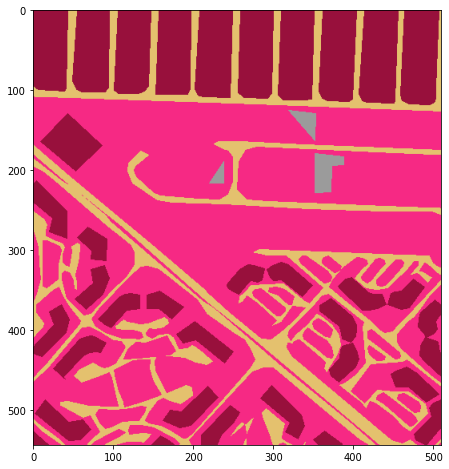

In [ ]:
# im_dim(get_img_arr(2,'masks',2))

(544, 510, 3)


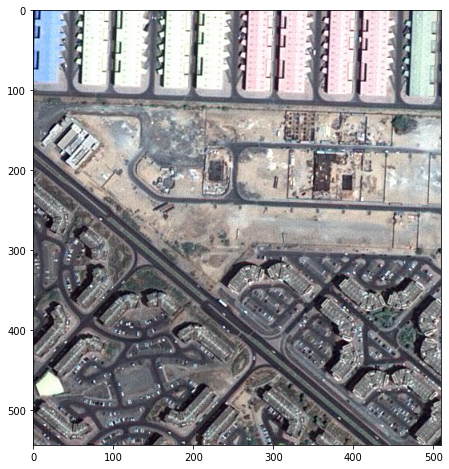

In [ ]:
# im_dim(get_img_arr(2,'images',2))

### 3. Explanation on patchify and patch_size leading up to the function that creates the dataset

We take the patch size in lowest multiple of 256. 
By using smaller patch sizes, 
- we can reduce the memory requirements of the model and process larger images that might not fit into memory otherwise.
- we can capture more local information about the image. This can be especially useful in cases where the overall structure of the image is less important than the details within specific regions of the image.

In [ ]:
# patch_size=256 # this crashes the kernel when fitting the model, lets try a few sizes now
# im_arr=get_img_arr(2,'images',2)
# # we want split each image into patches but these images are of any random size x*y
# # and patchify needs to be able to create patches perfectly without overlapping or losing out on information
# # so we first make patchify compatible with the image of any size by converting its x and y in nos. that are multiples of 256
# # ie we are calculating the maximum size of the image that can be divided into non-overlapping patches of a specified patch_size 
# sz_x = (im_arr.shape[1]//patch_size)*patch_size
# sz_y = (im_arr.shape[0]//patch_size)*patch_size

# im = Image.fromarray(im_arr)
# print(f'Size of image upon processing with patch size: {im.size[0]}x{im.size[1]}')
# im = im.crop((0,0, sz_x, sz_y))
# print(f'Size of image upon cropping the processed image: {im.size[0]}x{im.size[1]}')

# im_arr = np.array(im)
# patched_imgs_arr=patchify(im_arr,(patch_size,patch_size,3),step=patch_size)

# print(len(patched_imgs_arr))

Size of image upon processing with patch size: 510x544
Size of image upon cropping the processed image: 256x512
2


In [ ]:
# for img_arr in patched_imgs_arr:
#   print(img_arr.shape) # we have to get these images by last three dims

(1, 1, 256, 256, 3)
(1, 1, 256, 256, 3)


In [ ]:
# del img_arr,sz_x,sz_y

A little detour:

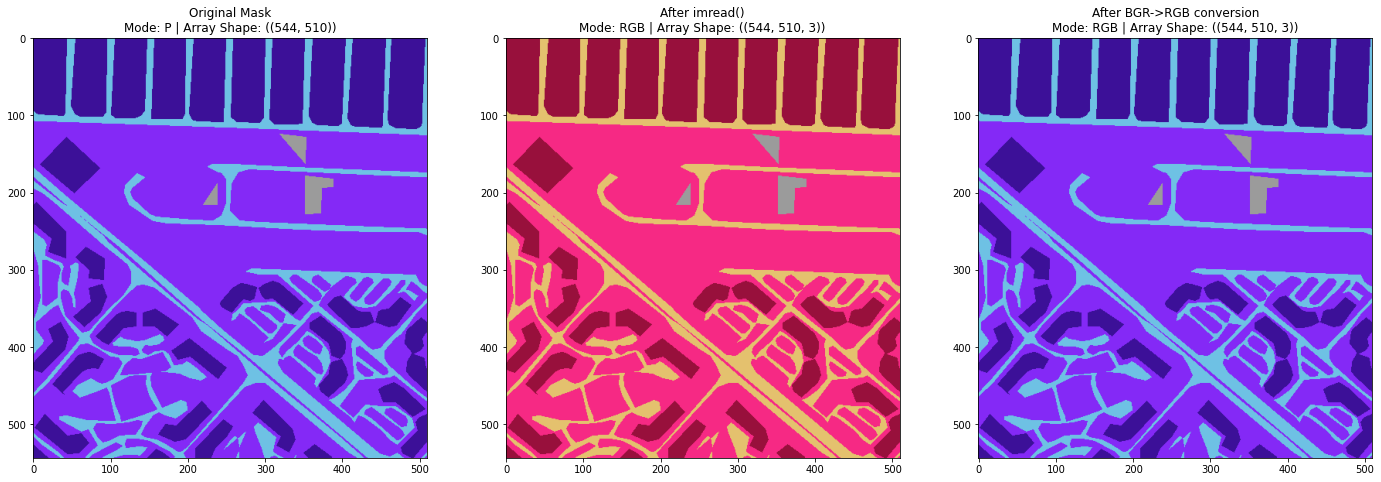

In [ ]:
# # imread alters the mode of colored image, so we need to handle the colored masks like so:
# # img_arr=cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
# # From cv2 docs: In the case of color images, the decoded images will have the channels stored in B G R order.
# # "P" (8-bit pixels, using a color palette)
# # "RGB" (3x8-bit pixels, true color)
# figure,axes=plt.subplots(1,3,figsize=(24,8))

# im=Image.open('/content/Semantic segmentation dataset/Tile 2/masks/image_part_002.png')
# axes[0].set_title(f'Original Mask\nMode: {im.mode} | Array Shape: ({np.array(im).shape})')
# axes[0].imshow(im)

# im_arr=get_img_arr(2,'masks',2)
# im=Image.fromarray(im_arr)
# axes[1].set_title(f'After imread()\nMode: {im.mode} | Array Shape: ({np.array(im).shape})')
# axes[1].imshow(im)

# im_arr=get_img_arr(2,'masks',2)
# im_arr = cv2.cvtColor(im_arr, cv2.COLOR_BGR2RGB)
# im=Image.fromarray(im_arr)
# axes[2].set_title(f'After BGR->RGB conversion\nMode: {im.mode} | Array Shape: ({np.array(im).shape})')
# axes[2].imshow(im)

In [ ]:
# del im,im_arr,figure

Let's continue to see what we have in patched_imgs_arr

In [ ]:
# patched_imgs_arr.shape

(2, 1, 1, 256, 256, 3)

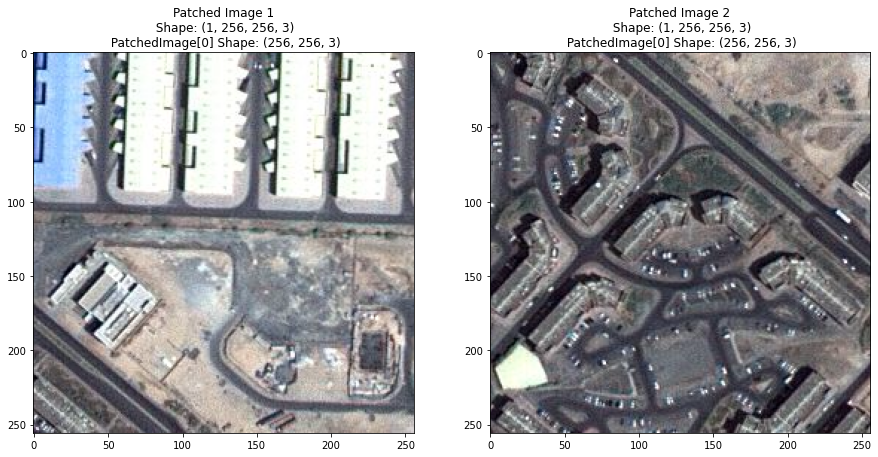

In [ ]:
# # figure,ax=plt.subplots(math.floor(len(patched_imgs_arr)/2),2,figsize=(15,8))
# # for i in range(patched_imgs_arr.shape[0]):
# #   for j in range(patched_imgs_arr.shape[1]):
# #     individual_patched_image = patched_imgs_arr[i,j,:,:]
# #     img=Image.fromarray(individual_patched_image[0])
# #     ax[i].set_title(f'Patched Image {i+1}\n Shape: {individual_patched_image.shape}\n PatchedImage[0] Shape: {individual_patched_image[0].shape}')
# #     ax[i].imshow(img)

# figure,ax=plt.subplots(math.floor(len(patched_imgs_arr)/2),2,figsize=(15,8))
# for i in range(patched_imgs_arr.shape[0]):
#   for j in range(patched_imgs_arr.shape[1]):
#     individual_patched_image = patched_imgs_arr[i,j,:,:]
#     img=Image.fromarray(individual_patched_image[0])
#     ax[i].set_title(f'Patched Image {i+1}\n Shape: {individual_patched_image.shape}\n PatchedImage[0] Shape: {individual_patched_image[0].shape}')
#     ax[i].imshow(img)

In [ ]:
# del i,j,figure,ax,axes,img,individual_patched_image

In [ ]:
# scaler=MinMaxScaler()
# # We have to then normalize the images only
# for i in range(patched_imgs_arr.shape[0]):
#   for j in range(patched_imgs_arr.shape[1]):
#     individual_patched_image = patched_imgs_arr[i,j,:,:]
#     individual_patched_image = scaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
#     individual_patched_image = individual_patched_image[0]
#     print(individual_patched_image.shape)
# # The fit_transform method of the scaler object is being called on the reshaped image array, 
# # where the reshape method is used to reshape the 4D image array into a 2D array with shape 
# # (num_pixels, num_channels) where num_pixels is 256*256 and num_channels is 3 (since the 
# # image has 3 color channels: red, green, and blue). After feature scaling, the reshape method 
# # is again used to reshape the 2D scaled image array back into its original 4D shape of (1,256,256,3)

(256, 256, 3)
(256, 256, 3)


In [ ]:
# del i,j,individual_patched_image

Now, we create the dataset.

In [ ]:
patch_size=256
scaler=MinMaxScaler()
image_dataset = []
mask_dataset = []

for im_type in ['images' , 'masks']:
  for tile_id in range(1,9):
    for im_id in range(1,10):
      img_arr = get_img_arr(tile_id,im_type,im_id)
      if img_arr is not None:
        if im_type == 'masks':
          img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

        size_x = (img_arr.shape[1]//patch_size)*patch_size
        size_y = (img_arr.shape[0]//patch_size)*patch_size
        img = Image.fromarray(img_arr)
        img = img.crop((0,0, size_x, size_y))
        img = np.array(img)
        patched_images = patchify(img, (patch_size, patch_size, 3), step=patch_size)
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if im_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              individual_patched_image = scaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              image_dataset.append(individual_patched_image)
            elif im_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [ ]:
del individual_patched_image, individual_patched_mask,img,img_arr,i,j,size_x,size_y,tile_id,scaler,im_type,im_id

In [ ]:
# convert both sets to a universal form of ndarray
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
# print(len(image_dataset))
# print(len(mask_dataset))

1305
1305


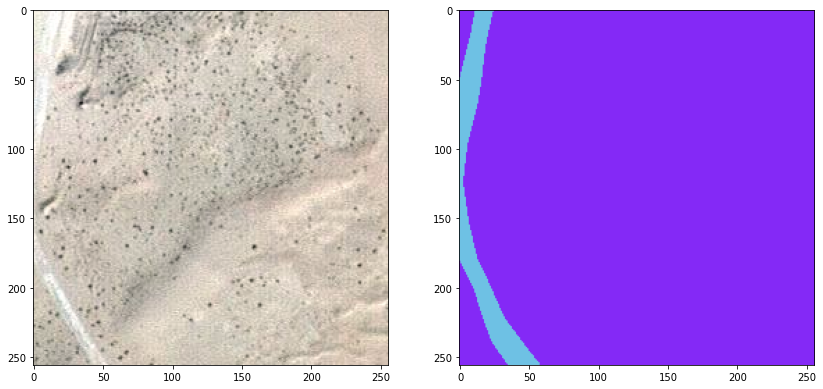

In [ ]:
# random_image_id = random.randint(0, len(image_dataset))

# plt.figure(figsize=(14,8))
# plt.subplot(121)
# plt.imshow(image_dataset[random_image_id])
# plt.subplot(122)
# plt.imshow(mask_dataset[random_image_id])

In [ ]:
# del patched_imgs_arr,patched_images,patch_size,random_image_id

Now, we apply encoding to the labels. Convert the hexcode to rgb code. From the json we have the labels. Let's say we have a label '#D0021B' then D0-208(R),02-2(G),1B-27(B). Like so we get the RGB encoded values for the labels.

In [ ]:
# temp='#D0021B'
# temp=temp.lstrip('#')
# print(int('D0',16))
# print(int('02',16))
# print(int('1B',16))

# temp_tuple=tuple(int(temp[i:i+2], 16) for i in (0,2,4))
# print(temp_tuple)
# print(np.array(temp_tuple))

208
2
27
(208, 2, 27)
[208   2  27]


In [ ]:
# del temp, temp_tuple

In [ ]:
# get the classes
_building = '#3C1098'
_building = _building.lstrip('#')
_building = np.array(tuple(int(_building[i:i+2], 16) for i in (0,2,4))) # 16 is base for hexcode
# print(_building)

_land = '#8429F6'
_land = _land.lstrip('#')
_land = np.array(tuple(int(_land[i:i+2], 16) for i in (0,2,4)))
# print(_land)

_road = '#6EC1E4'
_road = _road.lstrip('#')
_road = np.array(tuple(int(_road[i:i+2], 16) for i in (0,2,4)))
# print(_road)

_vegetation = '#FEDD3A'
_vegetation = _vegetation.lstrip('#')
_vegetation = np.array(tuple(int(_vegetation[i:i+2], 16) for i in (0,2,4)))
# print(_vegetation)

_water = '#E2A929'
_water = _water.lstrip('#')
_water = np.array(tuple(int(_water[i:i+2], 16) for i in (0,2,4)))
# print(_water)

_unlabeled = '#9B9B9B'
_unlabeled = _unlabeled.lstrip('#')
_unlabeled = np.array(tuple(int(_unlabeled[i:i+2], 16) for i in (0,2,4)))
# print(_unlabeled)

In [ ]:
# mask_dataset.shape # we have 1305 images of dim 256x256x3

(1305, 256, 256, 3)

The given code defines a function rgb_to_label that converts an RGB image with semantic segmentation annotations into a grayscale image where each pixel is assigned a label corresponding to a particular class. The function takes as input an RGB image with shape (height, width, 3) and returns a grayscale image with shape (height, width).

The function works by first creating a zero-initialized numpy array of the same shape as the input image. Then, for each class, it assigns a unique label value to all pixels in the input image that match the RGB color of that class. The classes and their corresponding RGB colors are defined outside of the function, in variables with names like _water, _land, etc.

After assigning labels to all pixels in the input image, the function returns the resulting grayscale image.

The main code block applies this function to all images in a dataset called mask_dataset. The dataset has shape (1305, 256, 256, 3), which means it contains 1305 RGB images, each with dimensions 256x256. The resulting grayscale images are appended to a list called labels.

In [ ]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == _water, axis=-1)] = 0
  label_segment[np.all(label == _land, axis=-1)] = 1
  label_segment[np.all(label == _road, axis=-1)] = 2
  label_segment[np.all(label == _building, axis=-1)] = 3
  label_segment[np.all(label == _vegetation, axis=-1)] = 4
  label_segment[np.all(label == _unlabeled, axis=-1)] = 5
  # print(label_segment)
  label_segment = label_segment[:,:,0]
  # print(label_segment)
  return label_segment

In [ ]:
labels = []
# for every image in masks dataset, convert the 
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [ ]:
del label,i

Let's see what's happening here.

In [ ]:
# mask_dataset[0].shape

(256, 256, 3)

In [ ]:
# # this is the input, now, we go into what thefunction
# lbl=mask_dataset[0]
# lbl_seg=np.zeros(lbl.shape,dtype=np.uint8)
# print(lbl_seg.shape)
# lbl_seg[np.all(lbl == _water, axis=-1)] = 0
# lbl_seg[np.all(lbl == _land, axis=-1)] = 1
# lbl_seg[np.all(lbl == _road, axis=-1)] = 2
# lbl_seg[np.all(lbl == _building, axis=-1)] = 3
# lbl_seg[np.all(lbl == _vegetation, axis=-1)] = 4
# lbl_seg[np.all(lbl == _unlabeled, axis=-1)] = 5
# print(lbl_seg)

(256, 256, 3)
[[[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 ...

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]]


In [ ]:
# lbl_seg = lbl_seg[:,:,0]
# print(lbl_seg)
# print(lbl_seg.shape)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
(256, 256)


In [ ]:
# del lbl,lbl_seg

Let's continue with the actual flow

In [ ]:
# creates a numpy array with shape (1305, 256, 256) containing the grayscale images for all 1305 input images.
labels = np.array(labels) # labels.shape=(1305, 256, 256)
# expands the dimension of the numpy array along the last axis using np.expand_dims(). 
# this adds a new dimension of size 1 to the numpy array, resulting in a new shape of (1305, 256, 256, 1). 
# this is commonly used when working with grayscale images in deep learning models that expect a 4D 
# input tensor, where the last dimension represents the number of color channels (1 for grayscale, 3 for RGB).
labels = np.expand_dims(labels, axis=3) # labels.shape=(1305, 256, 256, 1)

In [ ]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


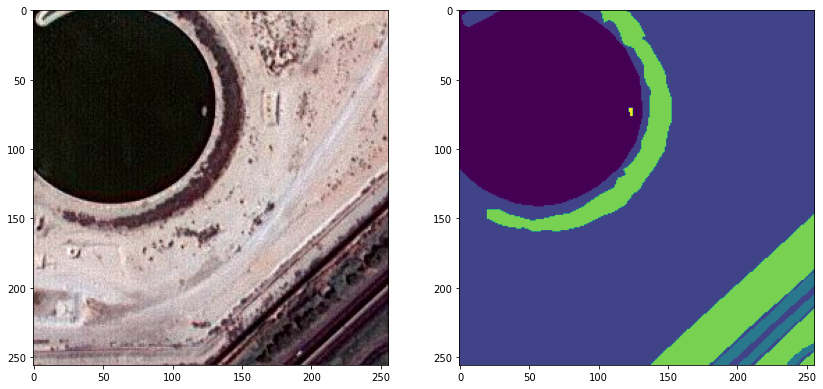

In [ ]:
# random_image_id = random.randint(0, len(image_dataset))

# plt.figure(figsize=(14,8))
# plt.subplot(121)
# plt.imshow(image_dataset[random_image_id])
# plt.subplot(122)
# #plt.imshow(mask_dataset[random_image_id])
# plt.imshow(labels[random_image_id][:,:,0])

In [ ]:
# del random_image_id

# Split into Train & Validation Data

In [ ]:
total_classes = len(np.unique(labels)) # 6

In [ ]:
# kernel crashes here on local machine
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [ ]:
# labels_categorical_dataset.shape

(1305, 256, 256, 6)

In [ ]:
train_data = image_dataset

In [ ]:
# train_data.shape

(1305, 256, 256, 3)

In [ ]:
SEED=42

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, labels_categorical_dataset, test_size=0.15, random_state=SEED)

In [ ]:
# print(X_train.shape)
# print(X_valid.shape)
# print(y_train.shape)
# print(y_valid.shape)

In [ ]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [ ]:
# print(image_height)
# print(image_width)
# print(image_channels)
# print(total_classes)

# Evaluation Metric

We'll be using a custom eval metric for this segmentation DL model called [Jaccard Index / Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) where 

**IoU = Area(Overlap)/ Area(Union)**

Higher the value of IoU, better is the model performing.

In [ ]:
# bk.sum(y_true_flatten) can be thought of as true positives, 
# bk.sum(y_pred_flatten) -> false positives, intersection -> false negatives
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [ ]:
# metrics = ["accuracy", jaccard_coef]

# Generating Loss Function

We define a custom loss function that fits our problem. We're using the focal loss (an extension of the cross entropy loss)
- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Model and Architecture of UNet

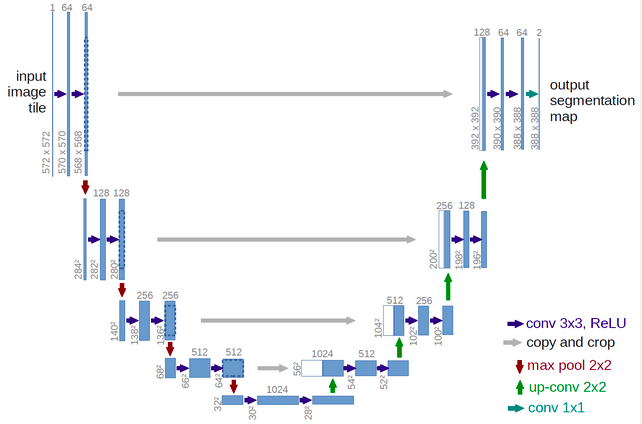

In [ ]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))
  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
def get_deep_learning_model(): 
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [ ]:
model = get_deep_learning_model()

In [ ]:
# # get model confiuration
# model.get_config()

# Model compilation

In [ ]:
K.clear_session()

In [ ]:
# model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

# Model Training/Loading

In [ ]:
# model_history = model.fit(train_dataset.batch(16),
#                           verbose=1,
#                           epochs=10,
#                           validation_data=valid_dataset.batch(16),
#                           shuffle=False)

In [ ]:
model = load_model("/content/model.hdf5",custom_objects={'dice_loss_plus_1focal_loss': total_loss,'jacard_coef':jaccard_coef})

OSError: ignored

In [ ]:
# model_weights = []
# for layer in model.layers:
#     layer_weights = layer.get_weights()
#     model_weights.append(layer_weights)

In [ ]:
# len(model_weights)

41

In [ ]:
# history_a = model_history

In [ ]:
# history_a.history

In [ ]:
# loss = history_a.history['loss']
# val_loss = history_a.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label="Training Loss")
# plt.plot(epochs, val_loss, 'r', label="Validation Loss")
# plt.title("Training Vs Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [ ]:
# jaccard_coef = history_a.history['jaccard_coef']
# val_jaccard_coef = history_a.history['val_jaccard_coef']

# epochs = range(1, len(jaccard_coef) + 1)
# plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
# plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
# plt.title("Training Vs Validation IoU")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [ ]:
# model_history.params

# Validate the predictions

In [ ]:
y_pred = model.predict(X_valid)

NameError: ignored

In [ ]:
len(y_pred)

196

In [ ]:
y_pred

array([[[[6.90958798e-02, 7.31835008e-01, 8.90202969e-02,
          5.13197929e-02, 1.87573116e-02, 3.99717540e-02],
         [3.89977396e-02, 8.81864548e-01, 4.23148423e-02,
          1.88900735e-02, 3.66779556e-03, 1.42651098e-02],
         [2.41434202e-02, 9.22660768e-01, 2.54095178e-02,
          1.31733119e-02, 3.00731231e-03, 1.16057163e-02],
         ...,
         [7.30682984e-02, 7.11990654e-01, 6.39015883e-02,
          1.00204319e-01, 2.24938039e-02, 2.83413157e-02],
         [8.41305852e-02, 7.04453528e-01, 5.48564345e-02,
          1.23365402e-01, 1.79871209e-02, 1.52068380e-02],
         [1.42518848e-01, 4.83763516e-01, 8.04883093e-02,
          2.00513110e-01, 4.91245203e-02, 4.35917825e-02]],

        [[2.91198157e-02, 8.96501064e-01, 2.95308083e-02,
          2.27942895e-02, 6.28394401e-03, 1.57702565e-02],
         [8.56805965e-03, 9.76584077e-01, 5.26630646e-03,
          5.51467529e-03, 8.89548217e-04, 3.17741930e-03],
         [5.01550455e-03, 9.86109436e-01, 2.4398

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
len(y_pred_argmax)

196

In [ ]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 2, 2, ..., 1, 1, 1],
        [1, 1, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 0, 1, 1],
        ...,
        [3, 3, 3, ..., 

In [ ]:
y_valid_argmax = np.argmax(y_valid, axis=3)

In [ ]:
y_valid_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [5, 5, 5, ..., 1, 1, 1],
        [5, 5, 5, ..., 1, 1, 1],
        [5, 5, 5, ..., 1, 1, 1]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 3, 3, 3],
        [2, 2, 1, ..., 3, 3, 3],
        [2, 2, 4, ..., 3, 3, 3]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 2],
        ...,
        [1, 1, 1, ..., 

# Comparing prediction results

- using test images using mask images and predicted result images.

In [ ]:
test_image_number = random.randint(0, len(X_valid))

test_image = X_valid[test_image_number]
ground_truth_image = y_valid_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 190ms/step


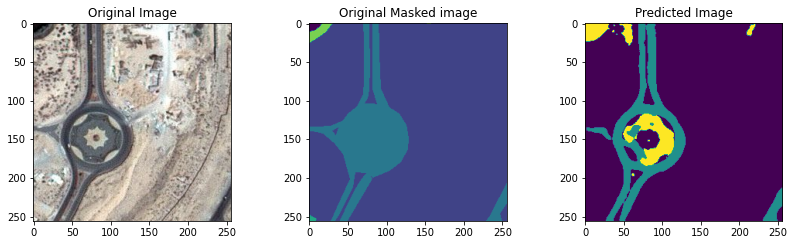

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [ ]:
# from keras.metrics import MeanIoU
# n_classes = 6
# IOU_keras = MeanIoU(num_classes=n_classes)  
# IOU_keras.update_state(y_valid_argmax, y_pred_argmax)
# print("Mean IoU =", IOU_keras.result().numpy())

# Mean IoU = 0.5665697

In [ ]:
# # evaluate the accuracy of the loaded model
# eval_metrics = model.evaluate(X_valid, y_valid)

# we get accuracy: xxx loss: xxx jaccard_coef: xxx

In [ ]:
# model.save("satellite_segmentation_full.h5")

# Perform Prediction using a custom image from Google Maps

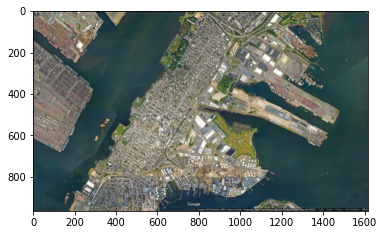

In [ ]:
plt.imshow(Image.open('/content/nyc1.png'))

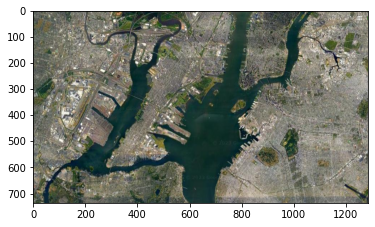

In [ ]:
plt.imshow(Image.open('/content/ny.png'))

In [ ]:
image = Image.open('/content/nyc1.png')
image = image.convert('RGB') # convert to RGB format
image = image.resize((256, 256))
image = np.array(image)
image = np.expand_dims(image, 0)
prediction = model.predict(image)

1/1 [==============================] - 0s 477ms/step


In [ ]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

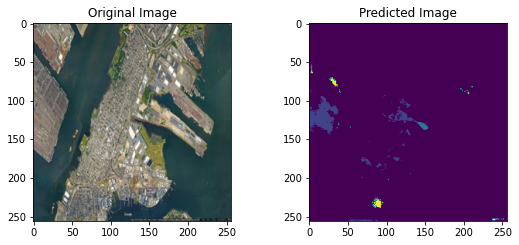

In [ ]:
temp_orig_img=Image.open('/content/nyc1.png')
temp_orig_img = temp_orig_img.resize((256, 256))

plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(temp_orig_img)
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

1/1 [==============================] - 0s 201ms/step


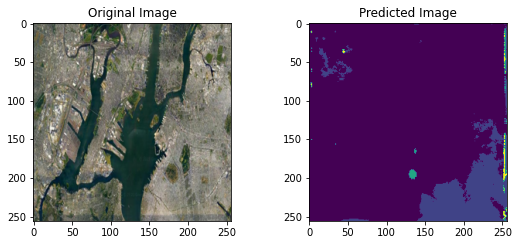

In [ ]:
image = Image.open('/content/ny.png')
image = image.convert('RGB') # convert to RGB format
image = image.resize((256, 256))
image = np.array(image)
image = np.expand_dims(image, 0)
prediction = model.predict(image)

predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

temp_orig_img=Image.open('/content/ny.png')
temp_orig_img = temp_orig_img.resize((256, 256))

plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(temp_orig_img)
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [ ]:
plt.imshow(Image.open('/content/heatmap/12_max_pooling2d_2.png'))

In [ ]:
plt.imshow(Image.open('/content/heatmap/16_max_pooling2d_3.png'))

# Collect Activation and Gradients output from Keras Model

In [ ]:
activations = ke.get_activations(model, image, nodes_to_evaluate=None, output_format='simple', auto_compile=True)

In [ ]:
!ls -lah /content/activations

In [ ]:
ke.display_activations(activations, cmap='viridis', save=True, directory='/content/activations')

In [ ]:
plt.imshow(Image.open('/content/activations/0_input_1.png'))

In [ ]:
plt.imshow(Image.open('/content/activations/1_conv2d.png'))

In [ ]:
plt.imshow(Image.open('/content/activations/40_conv2d_18.png'))

In [ ]:
image = Image.open('/content/fc-img1.jpg')
image = image.resize((256,256))
image_as_array = np.array(image)
image_as_array = image_as_array.astype(np.float32)
ke.display_heatmaps(activations, image_as_array, save=True, directory='/content/heatmap')

In [ ]:
plt.imshow(Image.open('/content/heatmap/0_input_1.png'))

In [ ]:
plt.imshow(Image.open('/content/heatmap/40_conv2d_18.png'))

In [ ]:
plt.imshow(Image.open('/content/heatmap/4_max_pooling2d.png'))

In [ ]:
plt.imshow(Image.open('/content/heatmap/8_max_pooling2d_1.png'))